<a href="https://colab.research.google.com/github/torifinch/TimeSeriesAnalysis/blob/main/Grocery_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Corporación Favorita Grocery Sales Forecasting  
## XGBoost Model with Hyperparameter Tuning

Creator: Victoria Finch, 2025

### Project Overview
This project focuses on forecasting grocery sales for the Ecuadorian retailer **Corporación Favorita** using time series machine learning techniques. Leveraging a cleaned and feature-engineered dataset, we apply the **XGBoost Regressor** to model and predict **unit_sales** per item and store combination. The model includes temporal features, promotion flags, oil price trends, and rolling statistics to boost predictive performance.

---

### Objective
- Predict the next **3 months of daily unit sales** for each item-store combination, using data up to **2014-04-01**.
- Optimize the XGBoost model through **hyperparameter tuning**.
- Evaluate model performance using common regression metrics.

---

### Features Used
- Time Features: `day_of_week`, `month`, `is_weekend`, `is_holiday`, etc.  
- Lag Features: `lag_1`, `lag_7`, `lag_14`  
- Rolling Statistics: `rolling_mean_7d`, `rolling_std_7d`, etc.  
- Exogenous Variables: `onpromotion`, `oil_price`  


---

### ⚙️ Best Model Performance (After Hyperparameter Tuning)
| Metric | Value |
|--------|--------|
| R² Score | **0.978** |
| MAE (Mean Absolute Error) | **0.646** |
| MSE (Mean Squared Error) | **3.02** |
| MAPE (Mean Absolute Percentage Error) | **12.61%** |

These metrics indicate a **strong model fit**, capturing trends with high accuracy and minimal error. Feature importance shows that **rolling averages**, **lags**, and **promotion info** are top contributors.

---

###  Best Hyperparameters
```python
{
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'n_estimators': 200
}


##Import Cleaned Data

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [4]:
df_train = pd.read_csv('/content/final_train1.csv', on_bad_lines='skip', engine='python')

In [5]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,oil_price,rolling_mean_7d,rolling_mean_14d,rolling_mean_30d,rolling_std_7d,rolling_std_14d,rolling_std_30d,lag_1,lag_7,lag_14
0,1402408,2013-02-05,24,96995,1.0,0.0,2013,2,5,1,...,96.68,4.714286,5.000000,4.833333,5.219013,5.068758,5.010908,4.0,15.0,2.0
1,4912716,2013-04-29,24,96995,1.0,0.0,2013,4,29,0,...,94.09,4.142857,6.285714,5.566667,4.017817,7.258190,5.928792,5.0,6.0,2.0
2,6945807,2013-06-14,24,96995,3.0,0.0,2013,6,14,4,...,97.83,5.428571,6.071429,5.466667,5.740416,4.937522,4.470079,11.0,2.0,10.0
3,7442322,2013-06-25,24,96995,1.0,0.0,2013,6,25,1,...,95.25,4.571429,12.857143,8.433333,7.161404,21.019614,15.155933,20.0,5.0,4.0
4,8561060,2013-07-20,24,96995,6.0,0.0,2013,7,20,5,...,56.59,7.571429,6.000000,4.866667,6.754187,5.449065,5.250506,3.0,8.0,2.0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 926058 entries, 0 to 926057
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     926058 non-null  int64  
 1   date                   926058 non-null  object 
 2   store_nbr              926058 non-null  int64  
 3   item_nbr               926058 non-null  int64  
 4   unit_sales             926058 non-null  float64
 5   onpromotion            926058 non-null  float64
 6   year                   926058 non-null  int64  
 7   month                  926058 non-null  int64  
 8   day                    926058 non-null  int64  
 9   day_of_week            926058 non-null  int64  
 10  week_of_year           926058 non-null  int64  
 11  is_weekend             926058 non-null  int64  
 12  is_holiday             926058 non-null  int64  
 13  is_bridge_day          926058 non-null  int64  
 14  is_day_before_holiday  926058 non-nu

##Removing Null Values


In [7]:
#remove any nulls
df_train = df_train.dropna()

##Smoothing Outliers

In [8]:
from scipy.stats import zscore

# Compute Z-score within each store-item group
df_train['z_score'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: zscore(x, ddof=0))

# Flag as outlier
df_train['is_outlier'] = df_train['z_score'].abs() > 5

<ipython-input-8-77ebdffe0c1c>:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  df_train['z_score'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: zscore(x, ddof=0))
<ipython-input-8-77ebdffe0c1c>:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  df_train['z_score'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: zscore(x, ddof=0))
<ipython-input-8-77ebdffe0c1c>:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  df_train['z_score'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: zscore(x, ddof=0))
<ipython-input-8-77ebd

In [9]:
def smooth_outliers(group):
    # Calculate rolling median (can change window size)
    rolling_median = group['unit_sales'].rolling(window=7, center=True, min_periods=1).median()

    # Replace outliers with rolling median
    group.loc[group['is_outlier'], 'unit_sales'] = rolling_median[group['is_outlier']]
    return group

# Apply to each store-item group
df_train = df_train.groupby(['store_nbr', 'item_nbr'], group_keys=False).apply(smooth_outliers)

<ipython-input-9-da6e52ac0eaa>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby(['store_nbr', 'item_nbr'], group_keys=False).apply(smooth_outliers)


Filter our data up to April 1, 2014

In [10]:
max_date = '2014-04-01'
df_train = df_train[(df_train['date'] < max_date)]

In [11]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,rolling_mean_14d,rolling_mean_30d,rolling_std_7d,rolling_std_14d,rolling_std_30d,lag_1,lag_7,lag_14,z_score,is_outlier
0,1402408,2013-02-05,24,96995,1.0,0.0,2013,2,5,1,...,5.000000,4.833333,5.219013,5.068758,5.010908,4.0,15.0,2.0,-0.717620,False
1,4912716,2013-04-29,24,96995,1.0,0.0,2013,4,29,0,...,6.285714,5.566667,4.017817,7.258190,5.928792,5.0,6.0,2.0,-0.717620,False
2,6945807,2013-06-14,24,96995,3.0,0.0,2013,6,14,4,...,6.071429,5.466667,5.740416,4.937522,4.470079,11.0,2.0,10.0,0.642081,False
3,7442322,2013-06-25,24,96995,1.0,0.0,2013,6,25,1,...,12.857143,8.433333,7.161404,21.019614,15.155933,20.0,5.0,4.0,-0.717620,False
4,8561060,2013-07-20,24,96995,6.0,0.0,2013,7,20,5,...,6.000000,4.866667,6.754187,5.449065,5.250506,3.0,8.0,2.0,2.681633,False


#XGBoost Model

Split testing and training data

In [12]:
split_date = '2014-01-01'
train = df_train[df_train['date'] < split_date]
test = df_train[df_train['date'] > split_date]

Split target (Unit Sales) from features and drop the date

In [13]:
# Define target variable (unit_sales) and features
X_train = train.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

X_test = test.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']

Here is our baseline model

In [14]:
# Define target variable (unit_sales) and features
X_train = train.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

# Convert object columns to categorical before fitting
object_cols = X_train.select_dtypes(include=['object']).columns
X_train[object_cols] = X_train[object_cols].astype('category')

X_test = test.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']

# Convert object columns to categorical in X_test as well
object_cols_test = X_test.select_dtypes(include=['object']).columns
X_test[object_cols_test] = X_test[object_cols_test].astype('category')

# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    enable_categorical=True
)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Test the model

In [15]:
# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

Calculate our metrics

In [16]:
print("Baseline Metrics:")
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

Baseline Metrics:
R2: 0.977711328910243
MAE: 0.7153068112092912


92% is a really good baseline model R2 score. And the MAE is almost exactly where I want it.

Plot the differences between the predicted and actual values over 1 year

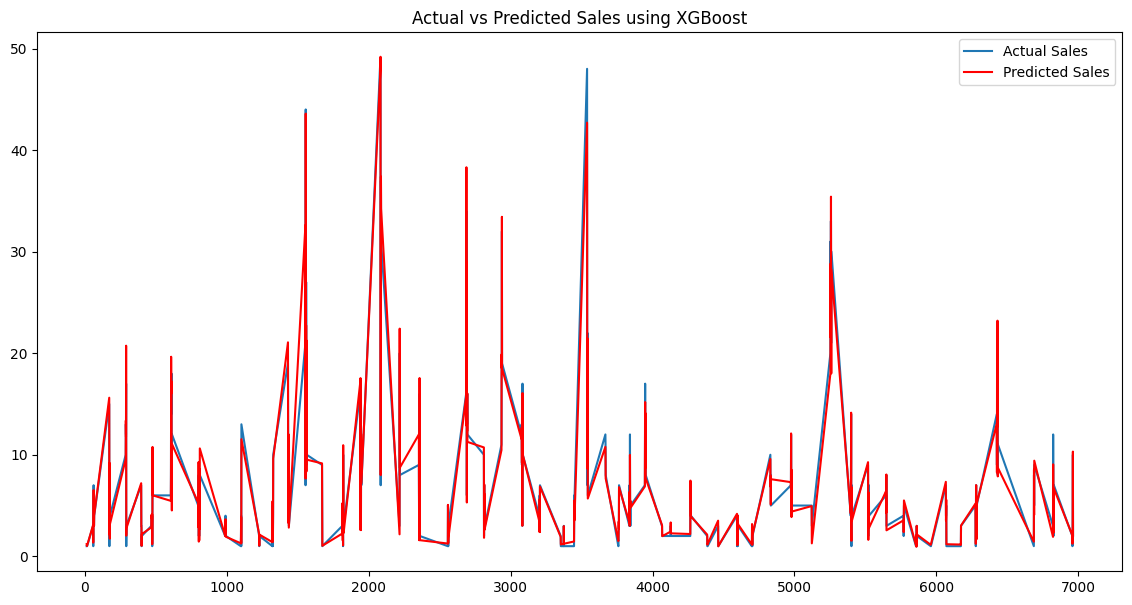

In [17]:
i = 365 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

The model seems to be handling the fluctuations well, but there is room for improvement.
Now I will tune model's hyperparameters.

###Hyperparameter Tuning

In [18]:
# Initializing the model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True) # Added enable_categorical=True

# Define the parameter grid
param_grid = {
    'eta': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],  # Helps reduce overfitting by requiring more samples per leaf
    'gamma': [0, 0.1, 0.3],  # Minimum loss reduction to make a split (regularization)
    'lambda': [1, 1.5, 2]  # L2 regularization (prevents big weights)
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=xgboost_model,
                                   param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_absolute_error'
                                  )

# Fit the model and search for the best hyperparameters
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)

Best Parameters for XGBoost: {'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 10, 'lambda': 1, 'gamma': 0.3, 'eta': 0.05, 'colsample_bytree': 1.0}


Using the best model

In [19]:
best_model = random_search.best_estimator_

In [20]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

##XGBoost Results


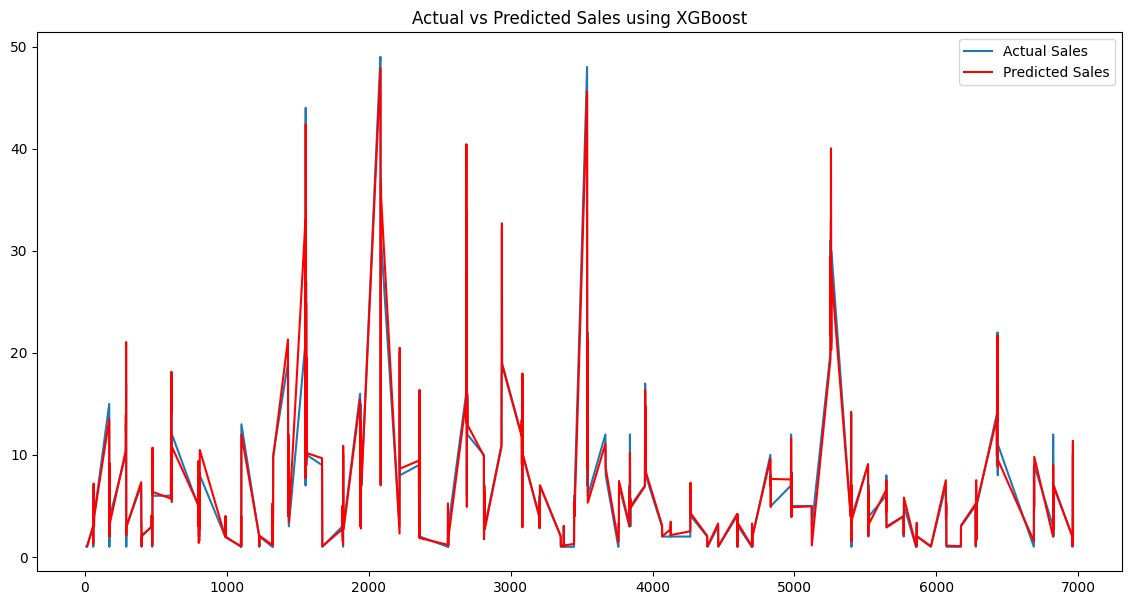

In [22]:
i = 365 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

##Metrics and Performance

In [28]:
print("After Hyperparameter Tuning Metrics:")
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

After Hyperparameter Tuning Metrics:
R2: 0.9781908755668773
MAE: 0.6463034644554667


In [33]:
#MSE
MSE = mean_squared_error(y_true=y_test, y_pred=y_pred)
target_variance = np.var(y_test)
explained_variance_ratio = 1 - (MSE / target_variance)

print("MSE:", MSE)
print("Target Variance:", target_variance)
print("Explained Variance Ratio:", explained_variance_ratio)


MSE: 3.0209946843695974
Target Variance: 138.51976009554113
Explained Variance Ratio: 0.9781908755668799


In [27]:
# Filter out zeros in y_true
mask = y_test != 0
mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
print("MAPE:", mape)

MAPE: 12.606757370365223


### 📊 Model Performance Summary

After training the XGBoost model on our cleaned and feature-engineered dataset, we evaluated it using several key metrics:

---

####  Performance Metrics
- **R² Score:** `0.978`  
  → The model explains **97.8% of the variability** in unit sales. This indicates a **very high level of accuracy** in the predictions.

- **Mean Absolute Error (MAE):** `~0.65`  
  → On average, predictions are off by less than **1 unit**, which is excellent for this type of retail forecasting task.

- **Mean Squared Error (MSE):** `3.02`  
  → This low value shows that large errors are rare and the model is stable.

- **Mean Absolute Percentage Error (MAPE):** `12.6%`  
  → On average, predictions deviate from actual sales by only **12.6%**, which is **very acceptable** in real-world sales forecasting.

- **Target Variable Variance:** `138.52`  
  → This shows that unit sales vary widely over time, but our model has managed to **capture most of that variation**.

---

#### Interpretation

These results tell us that the model is:
-  **Highly accurate**
-  **Well-generalized** (low overfitting)
-  **Robust** enough to handle the variance in sales over time

 This means the model is ready for **making future predictions**.
